In [1]:
!pip install import-ipynb
import import_ipynb
import HeatCurrentFunctions as QH

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc


g_1 = np.linspace(0.001, 0.009, 50) # Qubit 1 coupling to hot bath
g_2 = np.linspace(0.001, 0.009, 50) # Qubit 2 coupling to hot bath
g_3 = g_1
g_4 = g_2

c_t1 = np.zeros((50, 50)) # to store cos(theta_1)
s_t1 = np.zeros((50, 50)) # to store sin(theta_1)
c_t2 = np.zeros((50, 50)) 
s_t2 = np.zeros((50, 50))

Jm_list = np.empty((50, 50), dtype=object) # to store J_- operators for different g_1 and g_2, 
                                           #essentially using Eq. 4 from the additional notes written by Marcello
Jp_list = np.empty((50, 50), dtype=object) # to store J_+ operators for different g_1 and g_2
sx1_list = np.empty((50, 50), dtype=object) # substituting Eq.4 into J_x = J_+ + J_- to get a new collective resonator operator
#sx2_list = np.empty((50, 50), dtype=object)

for i, g1 in enumerate(g_1):
    for j, g2 in enumerate(g_2):
        # Mixing angles as arrays
        c_t1[i, j] = g_1[i] / np.sqrt((g_1[i])**2 + (g_2[j])**2)
        s_t1[i, j] = g_2[j] / np.sqrt((g_1[i])**2 + (g_2[j])**2)
        c_t2[i, j] = g_3[i] / np.sqrt((g_3[i])**2 + (g_4[j])**2)
        s_t2[i, j] = g_4[j] / np.sqrt((g_3[i])**2 + (g_4[j])**2)

        # Compute collective operators Jm and Jp at each point
        Jm_list[i,j] = np.sqrt(2) * (c_t1[i,j] * QH.sm1 + s_t1[i,j] * QH.sm2) 
        Jp_list[i,j] = np.sqrt(2) * (c_t1[i,j] * QH.sp1 + s_t1[i,j] * QH.sp2) 
        sx1_list[i, j] = np.sqrt(2) * (c_t1[i,j] * QH.sx1 + s_t1[i,j] * QH.sx2) 


In [3]:
# -------------------------------------------------------------------
# Could be thought of almost separate from the main code, mainly to calculate gamma_h and gamma_c for both qubits
# using current circuit paramters
# -------------------------------------------------------------------
h_2 = 6.626e-34
f_r = 5.6e9
C_r = 2.913e-12
Z_0 = 50
hbar = h_2/(2*np.pi)
w0 = 1          # LC resonator frequency (sets the unit scale)
Qf = 7.1798       # Resonator quality factor
N3 = 50
R_r = 16.4
C_T = 125.94023e-15
e_c = 1.6e-19
E_j_q1 = (27.59e9*h_2)
E_j_q2 = (27.59e9*h_2)
L_J1 = (hbar/(2*e_c))**2 * (1/E_j_q1)
L_J2 = (hbar/(2*e_c))**2 * (1/E_j_q2)
Z_T1 = np.sqrt(L_J1 / C_T)
Z_T2 = np.sqrt(L_J2 / C_T)

C_c_1 = g_1 * 4 * np.pi * Z_0 * C_T * C_r * f_r
C_c_2 = g_2 * 4 * np.pi * Z_0 * C_T * C_r * f_r


G1 = 2 * (C_c_1 / C_T) * np.sqrt(2 / (hbar * Z_T1))
G2 = 2 * (C_c_2 / C_T) * np.sqrt(2 / (hbar * Z_T2))

# Bath coupling strengths
gamma_h_q1   = (4*h_2*f_r*R_r*G1**2)/f_r   # Qubit 1 coupling to the hot bath using Eq. B19, normalized by resonator frequency
gamma_c_q1  =  gamma_h_q1  # Qubit 1 coupling to the cold bath using Eq. B19, normalized by resonator frequency
gamma_h_q2 = (4*h_2*f_r*R_r*G2**2)/f_r  # Qubit 2 coupling to the hot bath using Eq. B19, normalized by resonator frequency
gamma_c_q2 = gamma_h_q2 # Qubit 2 coupling to the cold bath using Eq. B19, normalized by resonator frequency
gamma_local_2 = 0.001 #0.001   # Parasitic relaxation
gamma_deph_2  = 0.001  # Pure dephasing (σ_z)
#gamma_h = 0.0075
#gamma_c = 0.0075





# Temperatures  (ℏ = k_B = 1)
T_local = 0.186    # Parasitic bath
T_h     = 1.2087    # Hot bath
T_c     = 0.186   # Cold bath
N =50

# Diagnostic: effective temperature of the composite resonator bath


#w_vals = np.linspace(0.5, 1.5, N)
#W1, W2 = np.meshgrid(w_vals, w_vals)


In [4]:
Q_ind_3   = np.zeros((N3, N3))   # independent current
Q_coll_3  = np.zeros((N3, N3))  # collective current
Ratio_3  = np.zeros((N3, N3))   # enhancement factor
Lambda_3  = np.zeros((N3, N3))   # minimum eigenvalue (positivity check)
Rho_ind_3 = np.zeros((N3, N3))
Rho_coll_3 = np.zeros((N3, N3)) # to store coherence terms of the density matrix

for i, g_h_q1 in enumerate(gamma_h_q1):
    for j, g_h_q2 in enumerate(gamma_h_q2):
        
        #Calculating a collective G, subsequently to calculate a collective gamma 
        # with G^2 ∝ g_1^2 + g_2^2
        C_c_coll =  np.sqrt(g_1[i]**2 + g_2[j]**2) * 4 * np.pi * Z_0 * C_T * C_r * f_r
              
        G_coll = 2 * (C_c_coll / C_T) * np.sqrt(2 / (hbar * Z_T2))
        gamma_h = (4*h_2*R_r*G_coll**2)
        gamma_c = gamma_h

        #coll_g_h = np.sqrt(g_h_q1**2 + g_h_q2**2) # A new collective coupling strength is defined as g_h_coll = sqrt(g_1^2 + g_2^2)
        g_c_q1 = gamma_c_q1[i]
        g_c_q2 = gamma_c_q2[j]
        #g_h = gamma_h[i]
        #g_c = gamma_c[i]
        
        #coll_g_c = np.sqrt(g_c_q1**2 + g_c_q2**2) # Similar to the collective coupling strength of the hot baths
        #Ts[i, j] = T_star(T_c, gamma_c_q1[i], T_h, gamma_h_q1[i], w0)

    # Independent-bath steady state and current
        rho_ind = QH.rho_ss_termic_indepentend_Asym(
            1, 1,
            gamma_local_2, T_local, gamma_deph_2,
            T_h, g_h_q1, g_h_q2, T_c, g_c_q1, g_c_q2, # Note: rho_ind now takes in gamma_h_q1, gamma_h_q2, gamma_c_q1, gamma_c_q2
            w0, Qf
        )
        Rho_ind_3[i, j] = np.real(rho_ind[1][1])
        Q_ind_3[i, j] = QH.Current_ind_Asym(1, 1, rho_ind, T_h, g_h_q1, g_h_q2, w0, Qf) # Q_ind now takes in gamma_h_q1, gamma_h_q2

        # Collective-bath steady state and current
        rho_coll = QH.rho_ss_termic_collective_Asym(
            1, 1,
            gamma_local_2, T_local, gamma_deph_2,
            T_h, gamma_h, T_c, gamma_c,
            w0, Qf, sx1_list[i,j] # now takes in a new J_x for each g_1 and g_2
        )
        Rho_coll_3[i, j] = np.real(rho_coll[1][2])
        Q_coll_3[i, j] = QH.Current_coll_Asym(1, 1, rho_coll, T_h, gamma_h, w0, Qf, Jm_list[i, j], Jp_list[i, j]) # Now takes in a new J_- and J_+ for each g_1 and g_2

        # Diagnostics
        Lambda_3[i, j] = np.min(np.linalg.eigvalsh(rho_coll.full()))
        Ratio_3[i, j]  = Q_coll_3[i, j] / Q_ind_3[i, j]

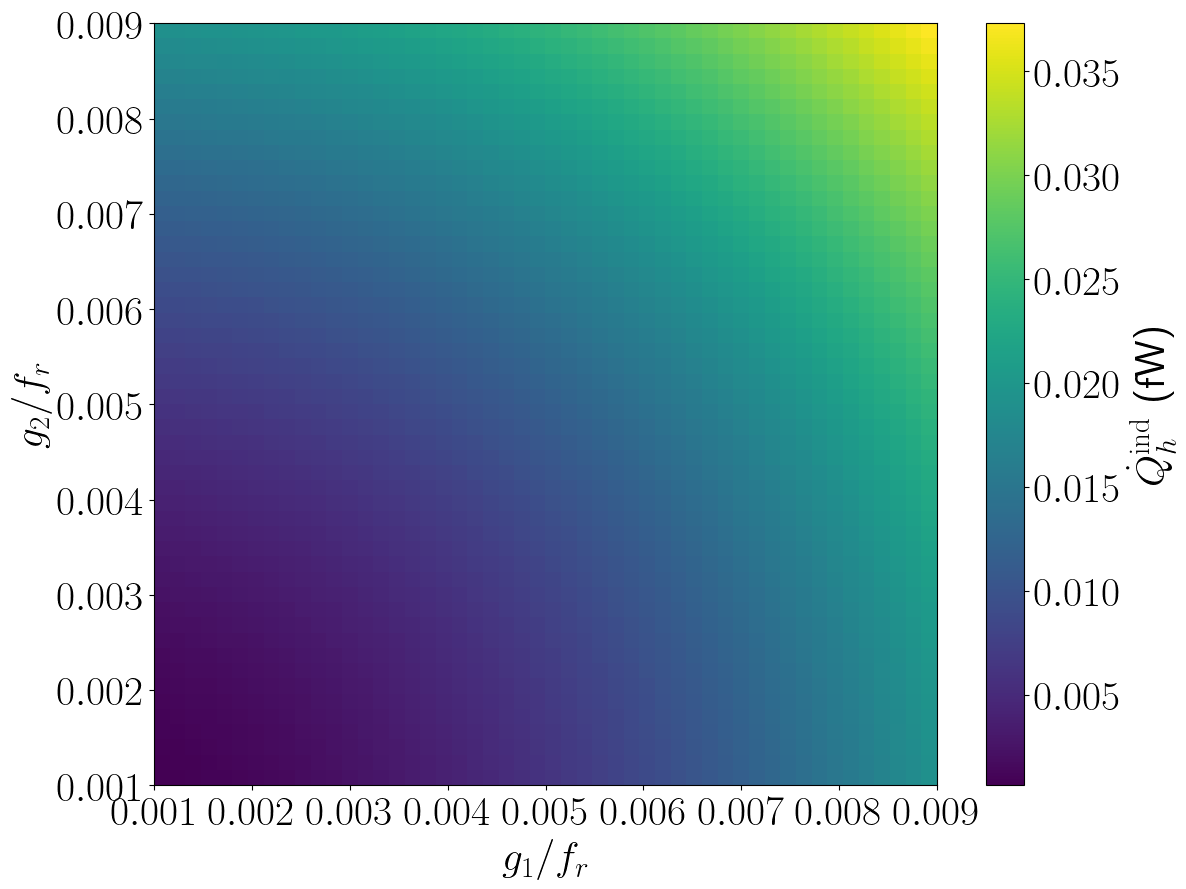

In [5]:
# Plotting independent heat current for coupling asymmetry

plt.figure(figsize=(12, 9))
rc('text',usetex=True)

cp = plt.imshow(
    0.662607015*(Q_ind_3), 
    extent=(g_1.min(), g_1.max(), g_2.min(),g_2.max()),
    aspect='auto',
    origin='lower'
)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

plt.xlabel(r'$g_1/f_r$', fontsize=30)
plt.ylabel(r'$g_2/f_r$', fontsize=30)


cbar = plt.colorbar(cp)
# Imposto la label con fontsize
cbar.set_label(r'$\dot Q^{\rm ind}_h$ (fW)', fontsize=30)
# Regolo la dimensione dei tick
cbar.ax.tick_params(labelsize=30)

plt.tight_layout()

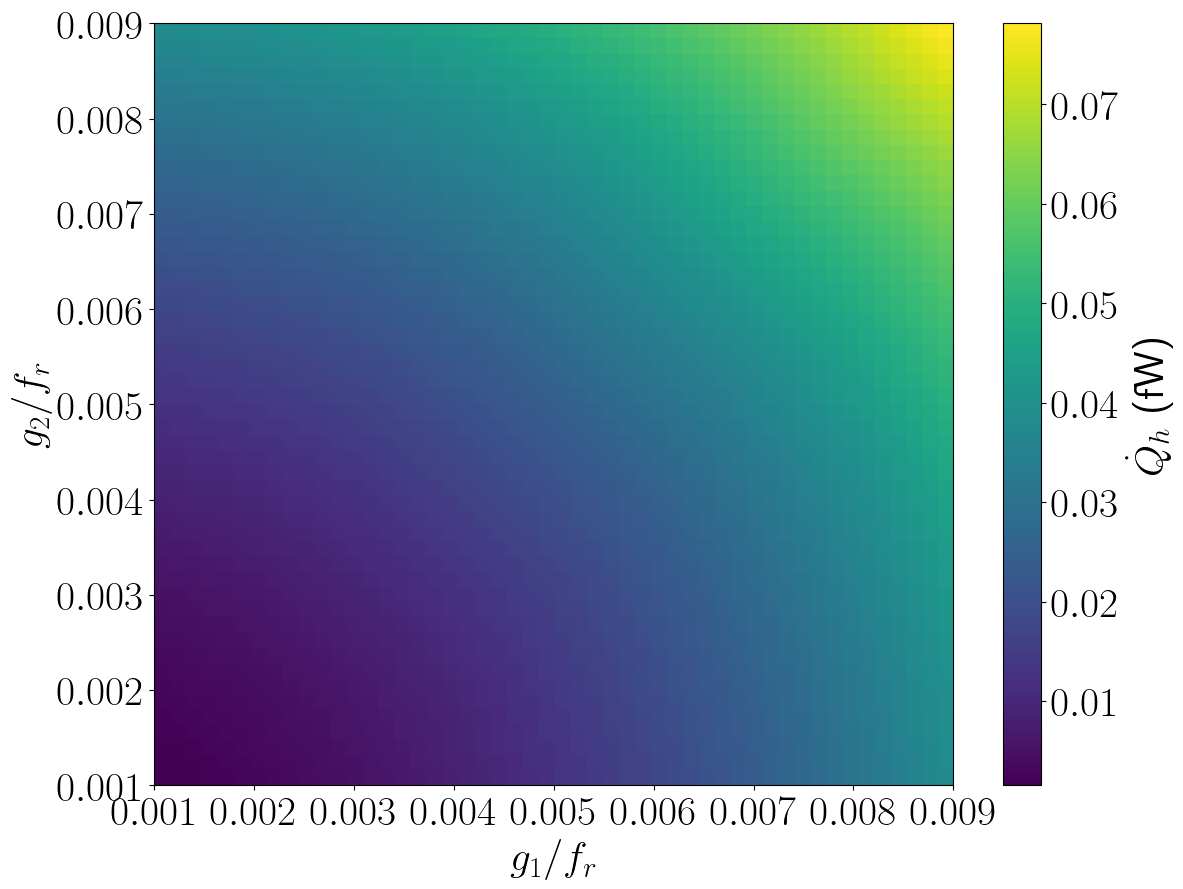

In [6]:
# Plotting collective heat current for coupling asymmetry

plt.figure(figsize=(12, 9))
rc('text',usetex=True)

cp = plt.imshow(
    0.662607015*(Q_coll_3),  # negative heat current for display
    extent=(g_1.min(), g_1.max(), g_2.min(),g_2.max()),
    aspect='auto',
    origin='lower'
)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

plt.xlabel(r'$g_1/f_r$', fontsize=30)
plt.ylabel(r'$g_2/f_r$', fontsize=30)


cbar = plt.colorbar(cp)
# Imposto la label con fontsize
cbar.set_label(r'$\dot Q_h$ (fW)', fontsize=30)
# Regolo la dimensione dei tick
cbar.ax.tick_params(labelsize=30)
plt.tight_layout()

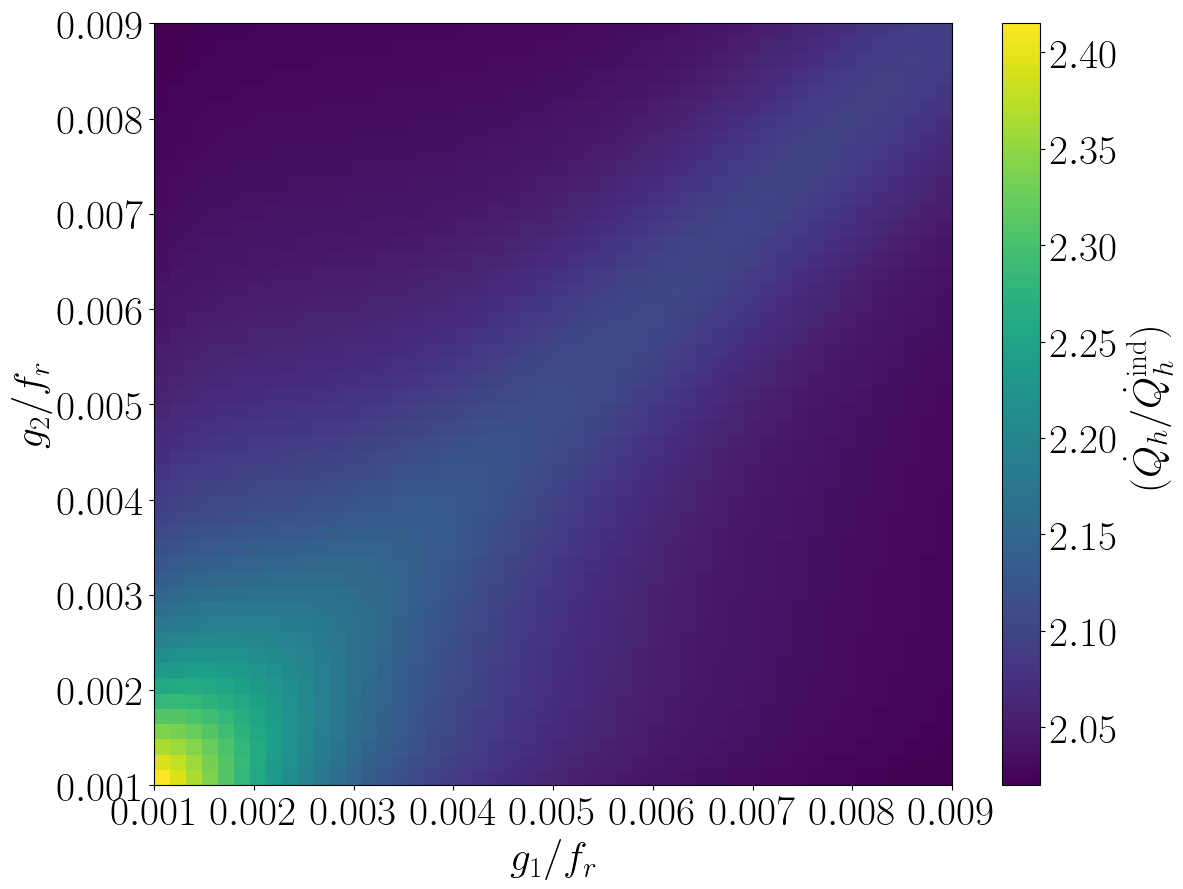

In [7]:
# Plotting Ratio between independent and collective heat current for coupling asymmetry

plt.figure(figsize=(12, 9))
rc('text',usetex=True)

cp = plt.imshow(
    Ratio_3,  
    extent=(g_1.min(), g_1.max(), g_2.min(),g_2.max()),
    aspect='auto',
    origin='lower'
)


plt.xticks(fontsize=30)
plt.yticks(fontsize=30)


plt.xlabel(r'$g_1/f_r$', fontsize=30)
plt.ylabel(r'$g_2/f_r$', fontsize=30)



# Catturo la colorbar in 'cbar'
cbar = plt.colorbar(cp)
# Imposto la label con fontsize
cbar.set_label(r'$(\dot Q_h/\dot Q_h^{\rm ind})$', fontsize=30)
# Regolo la dimensione dei tick
cbar.ax.tick_params(labelsize=30)

plt.tight_layout()

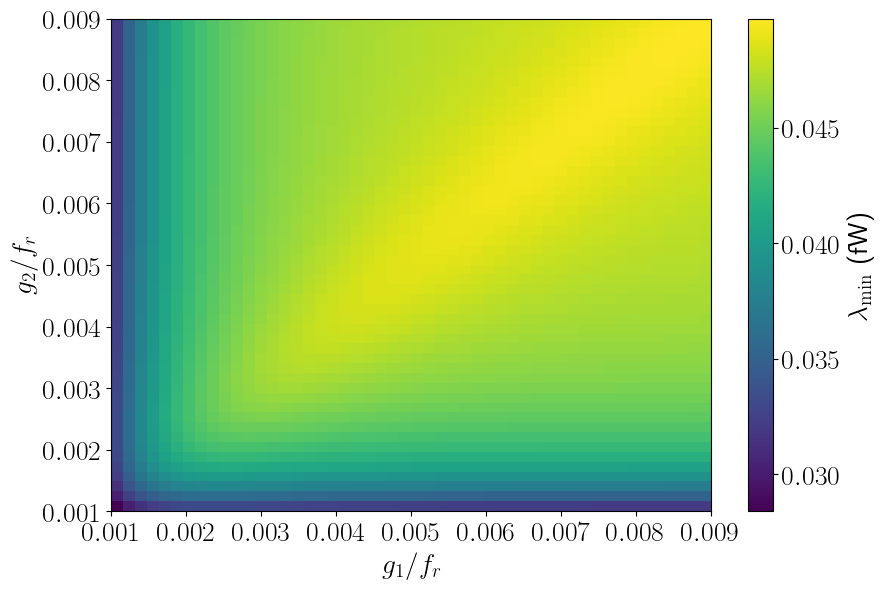

In [8]:
# Minimum eigenvalue of the collective density matrix

plt.figure(figsize=(9, 6))
rc('text',usetex=True)

cp = plt.imshow(
    Lambda_3,  # negative heat current for display
    extent=(g_1.min(), g_1.max(), g_2.min(),g_2.max()),
    aspect='auto',
    origin='lower'
)


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.xlabel(r'$g_1/f_r$', fontsize=20)
plt.ylabel(r'$g_2/f_r$', fontsize=20)




# Catturo la colorbar in 'cbar'
cbar = plt.colorbar(cp)
# Imposto la label con fontsize
cbar.set_label(r'$\lambda_{\rm min}$ (fW)', fontsize=20)
# Regolo la dimensione dei tick
cbar.ax.tick_params(labelsize=20)

plt.tight_layout()

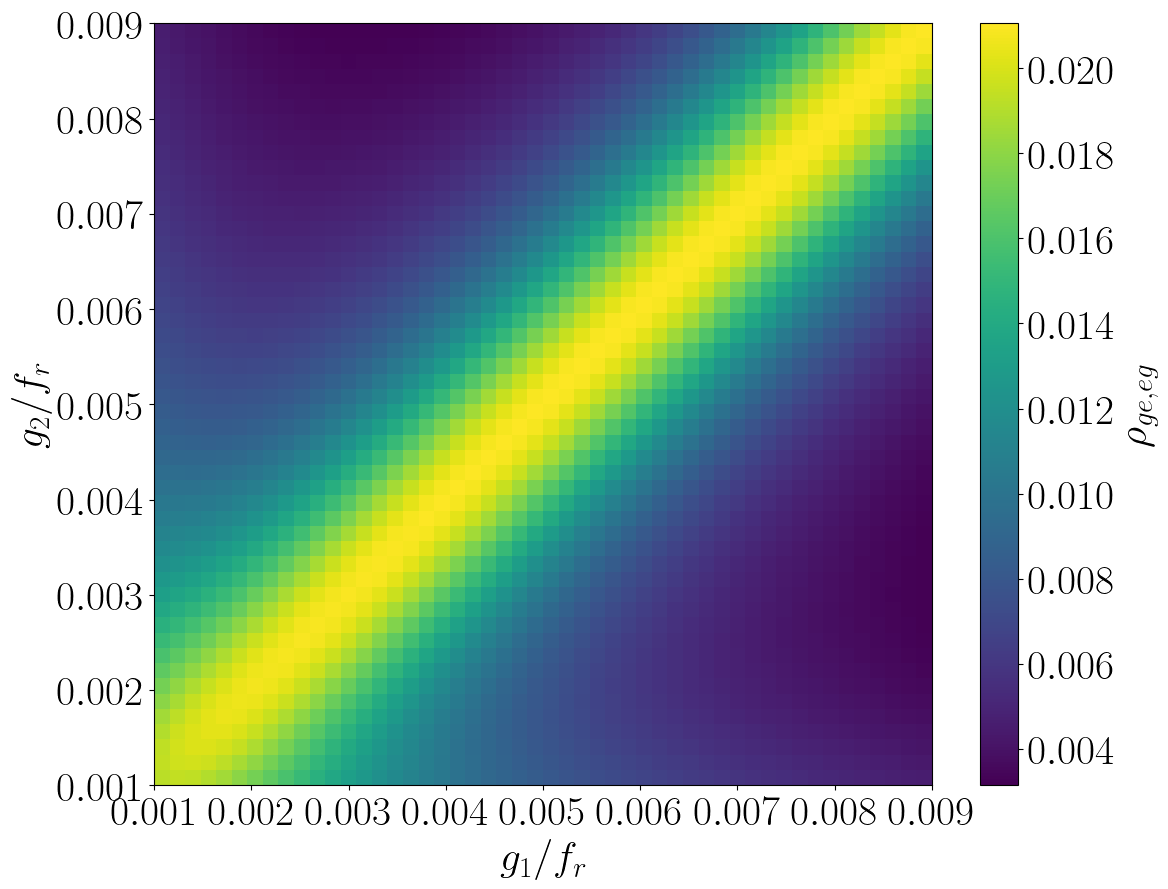

In [9]:
# Coherence term in the collective density matrix 

plt.figure(figsize=(12, 9))
rc('text',usetex=True)

cp = plt.imshow(
    Rho_coll_3,  # negative heat current for display
   extent=(g_1.min(), g_1.max(), g_2.min(),g_2.max()),
    aspect='auto',
    origin='lower'
)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

plt.xlabel(r'$g_1/f_r$', fontsize=30)
plt.ylabel(r'$g_2/f_r$', fontsize=30)


cbar = plt.colorbar(cp)
# Imposto la label con fontsize
cbar.set_label(r'$\rho_{ge, eg}$', fontsize=30)
# Regolo la dimensione dei tick
cbar.ax.tick_params(labelsize=30)
plt.tight_layout()